#### Grading Feedback
- 50

# IST 718 Group 17 Final Project

## Stock price prediction and analysis of the 30 tickers traded in the Dow Jones Industrial Average (^DJI)

The Dow 30, also known as the Dow Jones Industrial Average (DJIA), consists of 30 large, publicly-traded U.S. companies.

The companies in the Dow are always changing, depending on their prominence within the economy.

The Dow is considered to be a measure of the market's overall health as it takes the average of one share price of all the companies in the index.
Individuals can invest in the Dow through the SPDR Dow Jones Industrial Average ETF (DIA).

While both market indexes have the same aims, the DJIA and S&P 500 are different from each other in size and calculation methods.

Critics of the Dow believe it poorly represents the U.S. market as it only contains 30 large-cap companies and is not weighted by market cap.

It is calculated by taking the average of one share price of all the companies in the index divided by the dow divisor.

The dow divisor is determined based on corporate actions such as stock splits, etc.



In [ ]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./quotes_by_char.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/IST-718-Fall-2020/project_code_and_report-group17/master/DOW30_5yr.csv
fi

--2020-12-09 18:21:35--  https://raw.githubusercontent.com/IST-718-Fall-2020/project_code_and_report-group17/master/DOW30_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1770563 (1.7M) [text/plain]
Saving to: ‘DOW30_5yr.csv.1’

     0K .......... .......... .......... .......... ..........  2% 3.90M 0s
    50K .......... .......... .......... .......... ..........  5% 8.52M 0s
   100K .......... .......... .......... .......... ..........  8% 4.93M 0s
   150K .......... .......... .......... .......... .......... 11% 17.7M 0s
   200K .......... .......... .......... .......... .......... 14% 7.33M 0s
   250K .......... .......... .......... .......... .......... 17% 16.9M 0s
   300K .......... .......... .......... .......... .......... 20% 22.3M 0s
   35

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.sql import types
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import RegexTokenizer
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
import random
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DateType
from datetime import datetime
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import log 


spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

Data Preprocessing

In [ ]:
#Calculating log daily returns and adding a new column 'DailyReturn' to the df

df=spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("DOW30_5yr.csv")

df = df.withColumn("DailyReturn", log(df["Close"]/df["Open"]) * 100)

In [ ]:
display(df.toPandas())

,Date,Open,High,Low,Close,Volume,Ticker,DailyReturn
0,2/8/2013,67.7142,68.4014,66.8928,67.8542,158168416,AAPL,0.206538
1,2/11/2013,68.0714,69.2771,67.6071,68.5614,129029425,AAPL,0.717254
2,2/12/2013,68.5014,68.9114,66.8205,66.8428,151829363,AAPL,-2.451059
3,2/13/2013,66.7442,67.6628,66.1742,66.7156,118721995,AAPL,-0.042859
4,2/14/2013,66.3599,67.3771,66.2885,66.6556,88809154,AAPL,0.444611
...,...,...,...,...,...,...,...,...
36615,2/1/2018,87.5000,89.2500,87.3500,89.0700,17971012,XOM,1.778378
36616,2/2/2018,85.1300,86.0100,82.9978,84.5300,29822144,XOM,-0.707300
36617,2/5/2018,83.2800,83.9900,78.1300,79.7200,30452693,XOM,-4.368793
36618,2/6/2018,78.5100,80.3500,76.9000,78.3500,36262761,XOM,-0.204004


In [ ]:
#displaying the stocks in ascending order of their DailyReturn value
display(df.orderBy(df["DailyReturn"].asc()).toPandas().head())
print("\n")
#displaying the stocks in descending order of their DailyReturn value
display(df.orderBy(df["DailyReturn"].desc()).toPandas().head())

,Date,Open,High,Low,Close,Volume,Ticker,DailyReturn
0,10/14/2015,66.6100,67.950,60.0200,60.0300,80898117,WMT,-10.401028
1,7/31/2013,48.4375,48.725,42.7475,44.2525,90034484,V,-9.036244
2,10/28/2015,92.0400,93.000,84.4400,84.9500,24357537,WBA,-8.016042
3,8/25/2015,55.3900,55.410,51.0000,51.1700,22849832,MRK,-7.924565
4,8/25/2015,111.1100,111.110,103.5000,103.7400,103601599,AAPL,-6.863293


,Date,Open,High,Low,Close,Volume,Ticker,DailyReturn
0,8/24/2015,94.87,108.80,92.00,103.12,162206292,AAPL,8.338583
1,2/6/2018,66.63,71.95,66.19,71.89,23151934,DWDP,7.598225
2,2/6/2018,178.62,191.96,175.42,191.04,11682716,HD,6.722219
3,10/27/2015,89.20,95.74,88.96,95.16,13905239,WBA,6.467865
4,3/27/2015,30.01,33.00,29.85,32.00,73857226,INTC,6.420524


In [ ]:
#lowest daily return in all of the 30 stocks during the analysis period

df.orderBy(df["DailyReturn"].asc()).head(1)[0].asDict()



{'Close': 60.03,
 'DailyReturn': -10.401027916133636,
 'Date': '10/14/2015',
 'High': 67.95,
 'Low': 60.02,
 'Open': 66.61,
 'Ticker': 'WMT',
 'Volume': 80898117}

In [ ]:

df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- DailyReturn: double (nullable = true)



In [ ]:
df.describe().show()

+-------+---------+-----------------+------------------+-----------------+-----------------+--------------------+------+-------------------+
|summary|     Date|             Open|              High|              Low|            Close|              Volume|Ticker|        DailyReturn|
+-------+---------+-----------------+------------------+-----------------+-----------------+--------------------+------+-------------------+
|  count|    36620|            36620|             36620|            36620|            36620|               36620| 36620|              36620|
|   mean|     null|90.14560586018509|  90.8004906226115|89.49843476242377| 90.1739559694149|1.2137023656717641E7|  null|0.03215072593625405|
| stddev|     null|45.74932076617456|46.079022021532644|45.43526391051128|45.77042057853457|1.5544571098648878E7|  null| 0.9705117779228256|
|    min|1/10/2014|          20.1999|             20.49|            19.98|            20.23|              305358|  AAPL|-10.401027916133636|
|    max| 9/9

In [ ]:
#modify this code to find avg daily return for each of the ticker and print a pandas dataframe.
df.describe("DailyReturn").show()

+-------+-------------------+
|summary|        DailyReturn|
+-------+-------------------+
|  count|              36620|
|   mean|0.03215072593625405|
| stddev| 0.9705117779228256|
|    min|-10.401027916133636|
|    max|  8.338582522614644|
+-------+-------------------+



In [ ]:

func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

df = df.withColumn('Date', func(col('Date')))

In [ ]:
count_rows=df.groupBy("Ticker").count().show()

+------+-----+
|Ticker|count|
+------+-----+
|   MMM| 1259|
|   AXP| 1259|
|  AAPL| 1259|
|  CSCO| 1259|
|   XOM| 1259|
|   JPM| 1259|
|   DIS| 1259|
|  INTC| 1259|
|   MRK| 1259|
|    PG| 1259|
|   MCD| 1259|
|  DWDP|  109|
|    VZ| 1259|
|   TRV| 1259|
|     V| 1259|
|   PFE| 1259|
|   UNH| 1259|
|   IBM| 1259|
|   JNJ| 1259|
|   CVX| 1259|
+------+-----+
only showing top 20 rows



In [ ]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- DailyReturn: double (nullable = true)



#Inference

In [ ]:
#Grouping of stocks based on average volume. We can calculate the top and bottom most traded stocks.
t=df.groupBy('Ticker').agg({'Volume': 'mean'}).orderBy('avg(Volume)')
vol=t.toPandas().sort_values('avg(Volume)',ascending=False)
display(vol.head())
display(vol.tail())


,Ticker,avg(Volume)
29,AAPL,5.404790e+07
28,MSFT,3.386946e+07
27,INTC,2.932671e+07
26,CSCO,2.865435e+07
25,PFE,2.821891e+07


,Ticker,avg(Volume)
4,UNH,4.019056e+06
3,UTX,3.802276e+06
2,GS,3.249414e+06
1,MMM,2.302662e+06
0,TRV,1.858723e+06


In [ ]:
x=df.groupBy('Ticker').agg({'DailyReturn': 'mean'}).orderBy('avg(DailyReturn)')
ret=x.toPandas().sort_values('avg(DailyReturn)')
display(ret.head())
display(ret.tail())

,Ticker,avg(DailyReturn)
0,DWDP,-0.059507
1,MRK,-0.010909
2,UTX,0.002240
3,PFE,0.004641
4,DIS,0.006124


,Ticker,avg(DailyReturn)
25,MMM,0.069340
26,UNH,0.071399
27,BA,0.073646
28,MSFT,0.082041
29,INTC,0.085963


In [ ]:
#displaying the stocks in ascending order of their DailyReturn value
display(df.orderBy(df["DailyReturn"].asc()).toPandas().head())
print("\n")
#displaying the stocks in descending order of their DailyReturn value
display(df.orderBy(df["DailyReturn"].desc()).toPandas().head())

,Date,Open,High,Low,Close,Volume,Ticker,DailyReturn
0,2015-10-14,66.6100,67.950,60.0200,60.0300,80898117,WMT,-10.401028
1,2013-07-31,48.4375,48.725,42.7475,44.2525,90034484,V,-9.036244
2,2015-10-28,92.0400,93.000,84.4400,84.9500,24357537,WBA,-8.016042
3,2015-08-25,55.3900,55.410,51.0000,51.1700,22849832,MRK,-7.924565
4,2015-08-25,111.1100,111.110,103.5000,103.7400,103601599,AAPL,-6.863293


,Date,Open,High,Low,Close,Volume,Ticker,DailyReturn
0,2015-08-24,94.87,108.80,92.00,103.12,162206292,AAPL,8.338583
1,2018-02-06,66.63,71.95,66.19,71.89,23151934,DWDP,7.598225
2,2018-02-06,178.62,191.96,175.42,191.04,11682716,HD,6.722219
3,2015-10-27,89.20,95.74,88.96,95.16,13905239,WBA,6.467865
4,2015-03-27,30.01,33.00,29.85,32.00,73857226,INTC,6.420524


In [ ]:
#DowDuPont (DWDP) was inducted in the ^DJI on 2017-09-01

DWDP=df.filter(df.Ticker == "DWDP")
DWDP.show()

+----------+-----+-------+-------+-----+--------+------+--------------------+
|      Date| Open|   High|    Low|Close|  Volume|Ticker|         DailyReturn|
+----------+-----+-------+-------+-----+--------+------+--------------------+
|2017-09-01|66.66|   67.3|  65.66|67.18| 7341133|  DWDP|  0.7770511304553254|
|2017-09-05|67.02|  67.17|  64.98|64.98|10832692|  DWDP| -3.0911552068210004|
|2017-09-06| 65.2|  65.33|  64.01|64.87|10345913|  DWDP| -0.5074201707643262|
|2017-09-07| 64.6|  64.95|  64.22|64.68| 6382521|  DWDP| 0.12376239203500783|
|2017-09-08| 64.9|   65.2|  64.64|64.85| 8099999|  DWDP|-0.07707129475915514|
|2017-09-11|65.25|  67.16|   65.2|66.85|11567033|  DWDP|   2.422525734514925|
|2017-09-12| 68.2|  69.25|67.8007|68.52|14631020|  DWDP|  0.4681108606502695|
|2017-09-13| 68.9|   69.6|  68.29| 69.5| 9223585|  DWDP|  0.8670574551133576|
|2017-09-14| 69.6|   70.3|  69.22|70.02|12264841|  DWDP|  0.6016348186145694|
|2017-09-15|70.26|   70.7|   69.5|69.86|32382148|  DWDP| -0.5709

#Visualizations


In [ ]:
dow_pd=df.toPandas()

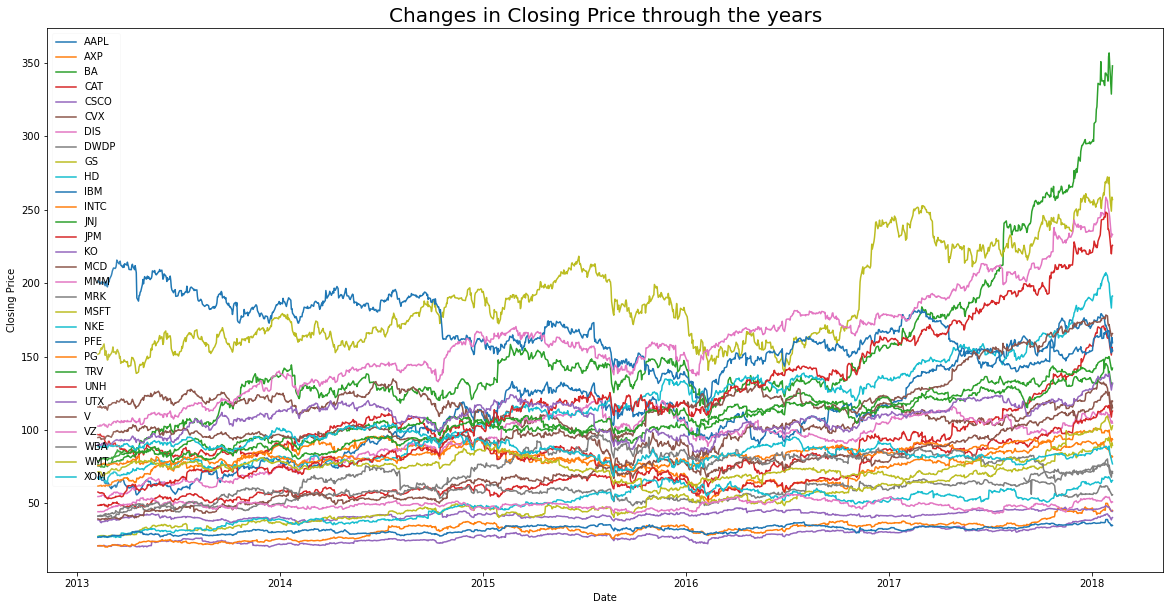

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))


for name, group in dow_pd.groupby('Ticker'):
    group.plot(x="Date", y='Close', ax=ax, label=name)
  
plt.title("Changes in Closing Price through the years",fontsize=20)
plt.xlabel("Date",fontsize=10)
plt.ylabel("Closing Price",fontsize=10)
ax.legend(fancybox=True, framealpha=0.1)

In [ ]:
# normalize the stock closing price to see a clearer pattern

first_day_closing = dow_pd.groupby('Ticker').transform('first')

normalize_DOW30_pd = dow_pd

normalize_DOW30_pd['Close'] = dow_pd['Close']/first_day_closing['Close']

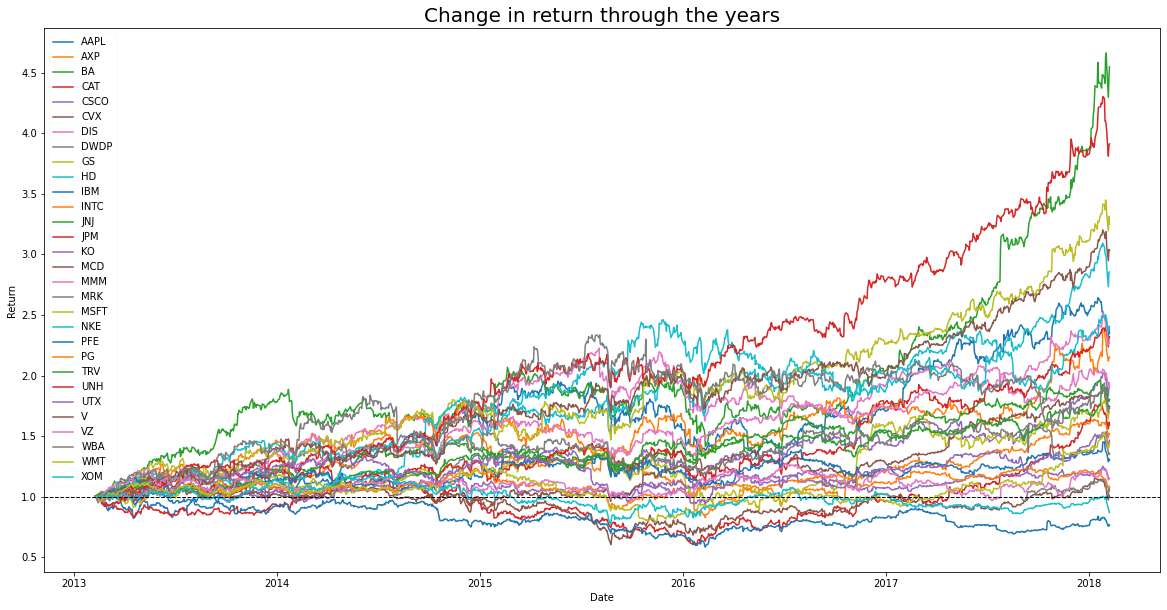

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))


for name, group in normalize_DOW30_pd.groupby('Ticker'):
    group.plot(x="Date", y='Close', ax=ax, label=name)
  
plt.title("Change in return through the years",fontsize=20)

plt.xlabel("Date",fontsize=10)

plt.ylabel("Return",fontsize=10)

plt.axhline(y=1, lw = 1, color = 'black',linestyle = '--')

ax.legend(fancybox=True, framealpha=0.1)

Text(0, 0.5, 'Stock Volume')

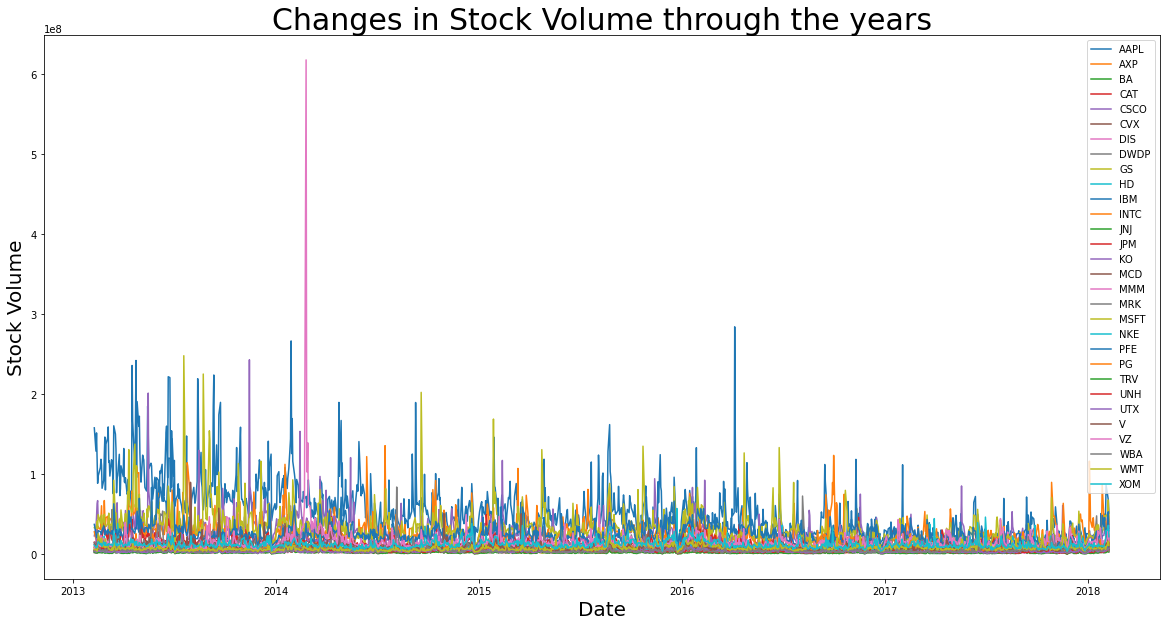

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

for name, group in dow_pd.groupby('Ticker'):
    group.plot(x="Date", y='Volume', ax=ax, label=name)

plt.title("Changes in Stock Volume through the years",fontsize=30)

plt.xlabel("Date",fontsize=20)

plt.ylabel("Stock Volume",fontsize=20)

Text(0, 0.5, 'Daily percentage change')

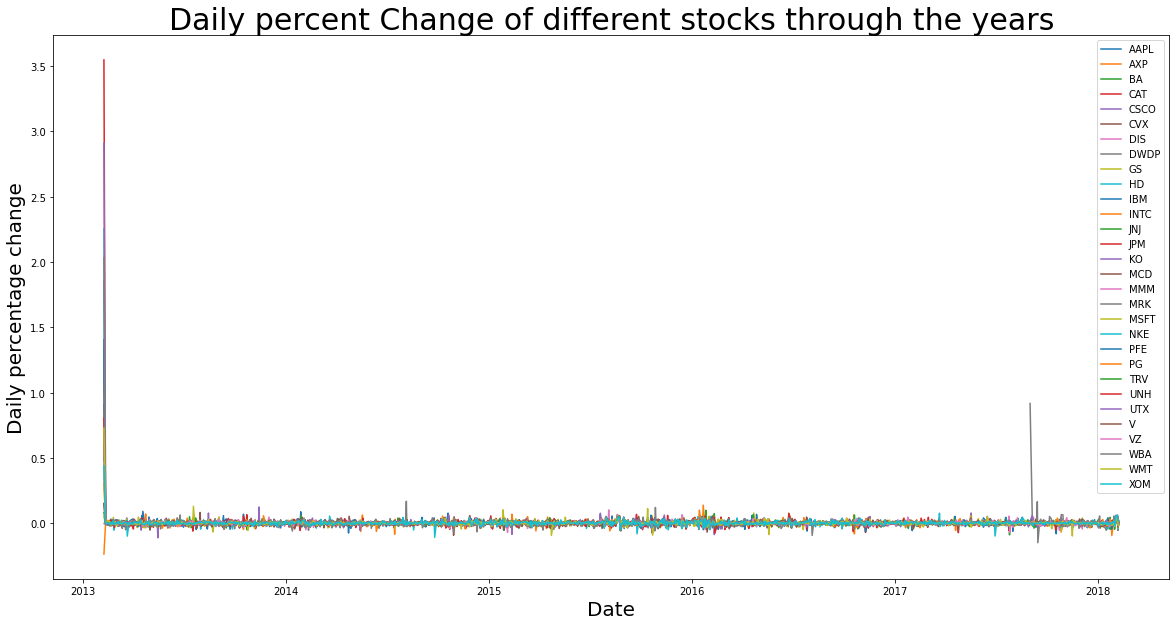

In [ ]:
# Daily percentage change of stock price
daily_percentage_change = dow_pd
daily_percentage_change['Change'] = (dow_pd['Close'].shift(1) - dow_pd['Close'])/dow_pd['Close']

fig, ax = plt.subplots(figsize=(20, 10))

for name, group in daily_percentage_change.groupby('Ticker'):
    group.plot(x="Date", y='Change', ax=ax, label = name)
plt.title("Daily percent Change of different stocks through the years",fontsize=30)
plt.xlabel("Date",fontsize=20)
plt.ylabel("Daily percentage change",fontsize=20)

Text(0, 0.5, 'Closing Price')

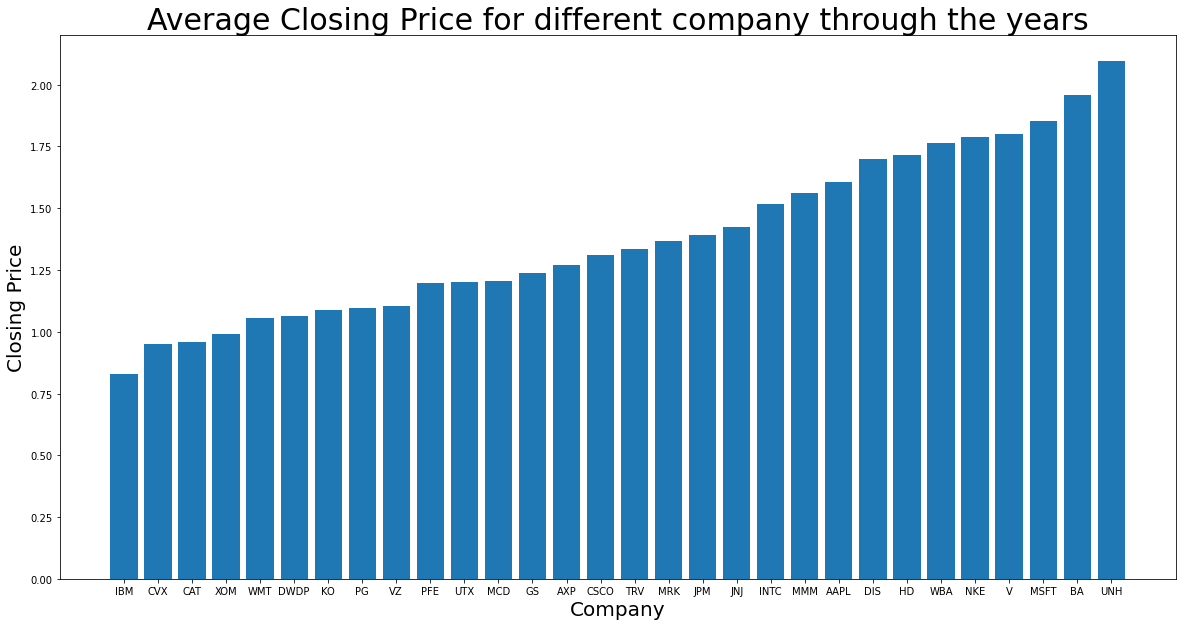

In [ ]:
#Average Closing Price for different company through the years
Avg_close_pd = dow_pd.groupby('Ticker')['Close'].mean().to_frame()
Avg_close_pd.reset_index(level = 0, inplace = True)
Avg_close_pd = Avg_close_pd.sort_values('Close')

fig, ax = plt.subplots(figsize=(20, 10))

plt.bar(Avg_close_pd['Ticker'], Avg_close_pd['Close'])

plt.title("Average Closing Price for different company through the years",fontsize=30)
plt.xlabel("Company",fontsize=20)
plt.ylabel("Closing Price",fontsize=20)

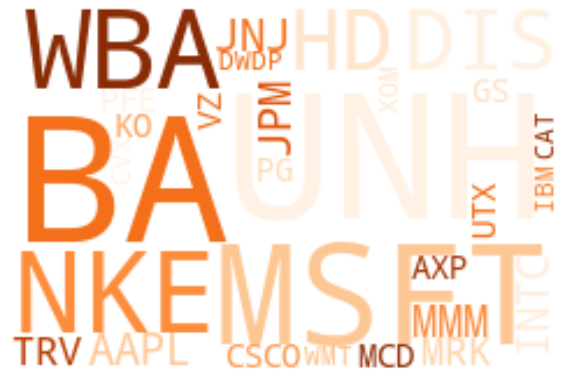

In [ ]:
from wordcloud import WordCloud


Avg_close_pd2 = Avg_close_pd.sort_values('Close',ascending=False)

fig, ax = plt.subplots(figsize=(10 ,10))
wordcloud = WordCloud(width=240, height=160,colormap="Oranges", background_color="white" ).generate(' '.join(str(v) for v in Avg_close_pd2['Ticker']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

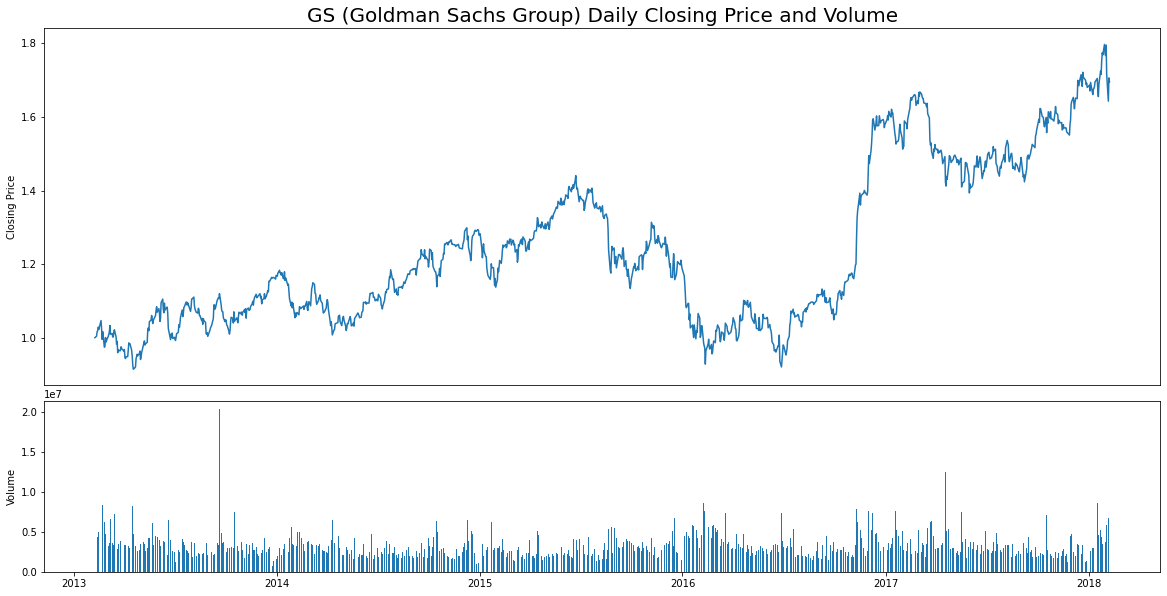

In [ ]:
BA_pd = dow_pd[dow_pd.Ticker == 'BA'] #Boeing Co.
GS_pd = dow_pd[dow_pd.Ticker == 'GS'] #Goldman Sachs

plt.figure(figsize=(20,10))

top = plt.subplot2grid((6,6), (0, 0), rowspan=4, colspan=6)

bottom = plt.subplot2grid((6,6), (4,0), rowspan=2, colspan=6)

top.plot(GS_pd['Date'], GS_pd['Close']) 

bottom.bar(GS_pd['Date'], GS_pd['Volume']) 

top.axes.get_xaxis().set_visible(False)

top.set_title('GS (Goldman Sachs Group) Daily Closing Price and Volume',fontsize=20)

top.set_ylabel('Closing Price',fontsize=10)

bottom.set_ylabel('Volume',fontsize=10);

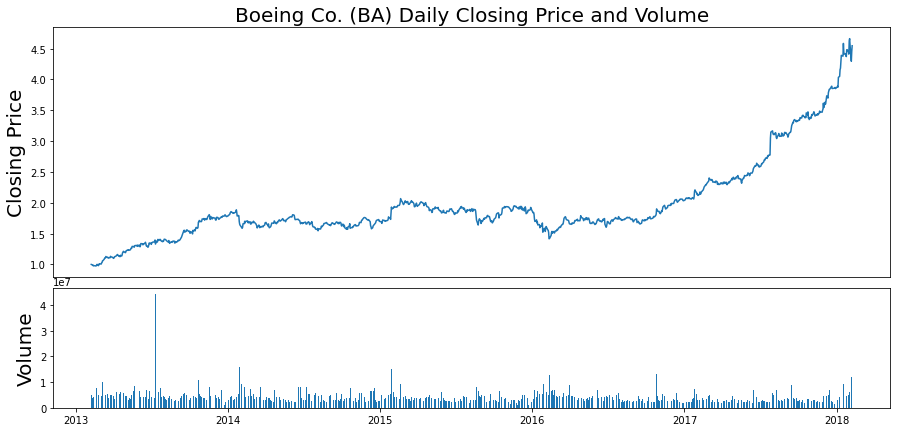

In [ ]:
plt.figure(figsize=(15,7))

top = plt.subplot2grid((6,6), (0, 0), rowspan=4, colspan=6)

bottom = plt.subplot2grid((6,6), (4,0), rowspan=2, colspan=6)

top.plot(BA_pd['Date'], BA_pd['Close']) 

bottom.bar(BA_pd['Date'], BA_pd['Volume']) 

top.axes.get_xaxis().set_visible(False)

top.set_title('Boeing Co. (BA) Daily Closing Price and Volume',fontsize=20)

top.set_ylabel('Closing Price',fontsize=20)

bottom.set_ylabel('Volume',fontsize=20);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

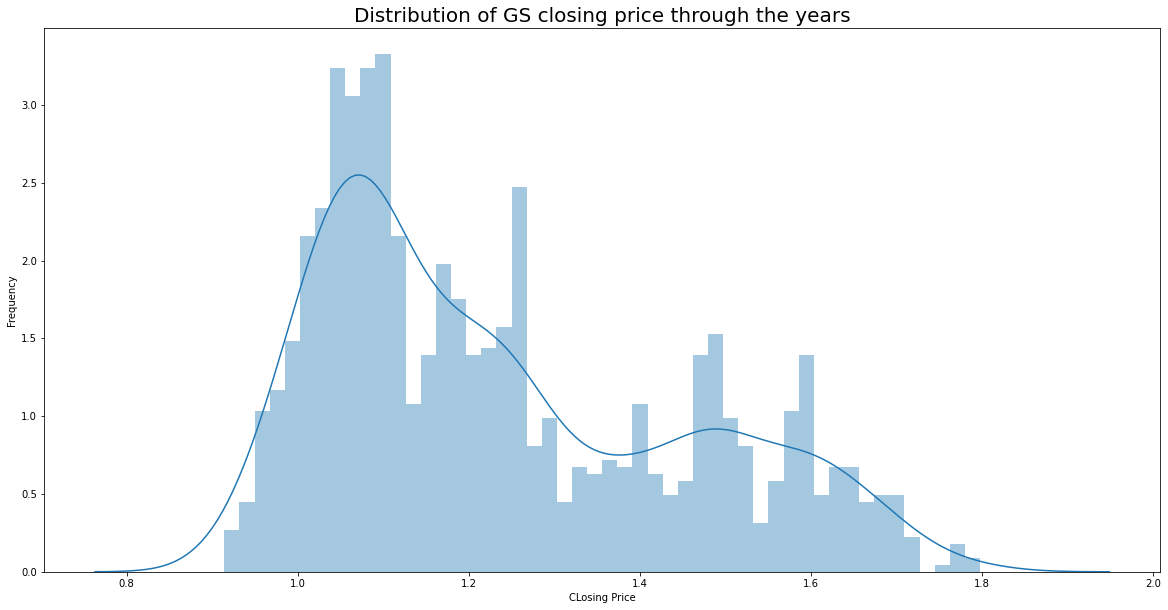

In [ ]:
import seaborn as sns

plt.figure(figsize=(20,10))

sns.distplot(GS_pd['Close'], bins=50)

plt.title("Distribution of GS closing price through the years",fontsize=20)

plt.xlabel("CLosing Price",fontsize=10)

plt.ylabel("Frequency",fontsize=10)

#Machine Learning Models to predict the close price
1. Apple Stock (Close) Price Prediction using Random Forest ML model (RandomForestRegressor)

2. GBT model for MSFT

3. Linear Regression to predict close price for JNJ

## 1. Apple Stock (Close) Price Prediction using Random Forest ML model (RandomForestRegressor)



Root Mean Squared Error (RMSE) on test data = 1.2826


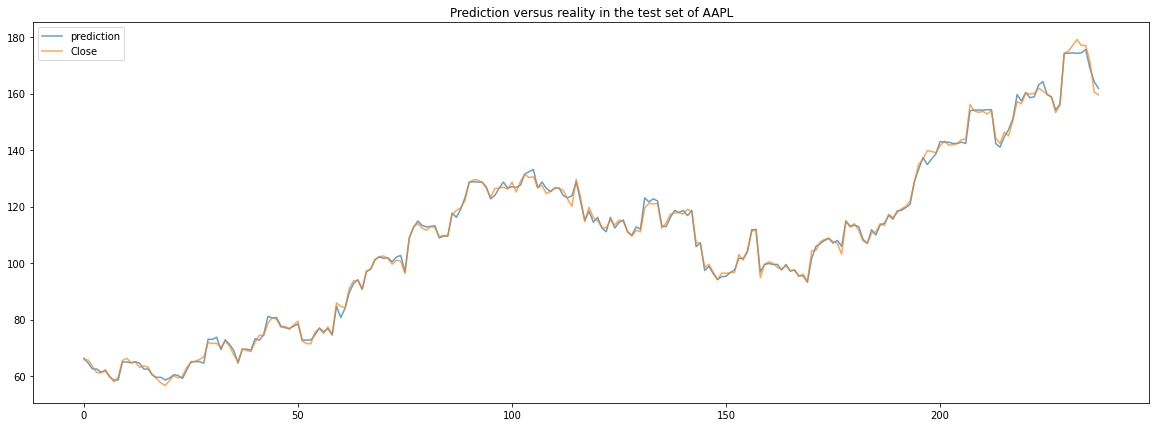

In [ ]:
##
AAPL=df.filter(df.Ticker == "AAPL")
AAPL=AAPL.select("Date","Open","High","Low","Volume","Close")
def RF(AAPL,grid_search=False):
  trainingData, testData = AAPL.randomSplit([0.8, 0.2])
  va = VectorAssembler().setInputCols(trainingData.columns[1:5]).setOutputCol('features')
  rf = RandomForestRegressor(labelCol="Close", featuresCol="features",maxDepth=9,numTrees=200)
  pipe = Pipeline(stages=[va, rf])
  evaluator_rf = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName='rmse')
  if grid_search:
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [2,10,25,50,100,200,500,1000]) \
        .addGrid(rf.maxDepth, [2,4,6,8,9,10,11,12]) \
        .build()


    crossval = CrossValidator(estimator=pipe,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator_rf,
                              numFolds=3)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters to Train a GBT model.
    model_rf=crossval.fit(trainingData)
    hyperparams = model_rf.getEstimatorParamMaps()[np.argmax(model_rf.avgMetrics)]
    print(hyperparams)
    model_rf = model_rf.bestModel
  else:
    model_rf = pipe.fit(trainingData)

  # Make predictions.
  predictions = model_rf.transform(testData)

  #RMSE 
  rmse = evaluator_rf.evaluate(predictions)
  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
  # print("Feature importance as of column index:",model_rf.stages[-1].featureImportances)
  ##
  return predictions,testData,rmse
predictions,testData,rmse = RF(AAPL)

#Line plot comparing Prediction versus reality in the test set of AAPL
pred= predictions.toPandas()
test=testData.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(test)), test.Close, alpha=0.7, label='Close' );
plt.title('Prediction versus reality in the test set of AAPL')
plt.legend();

In [ ]:
#displaying the test data after transformation

predictions.toPandas().head(10)


,Date,Open,High,Low,Volume,Close,features,prediction
0,2013-02-15,66.9785,67.1656,65.7028,97924631,65.7371,"[66.9785, 67.1656, 65.7028, 97924631.0]",66.321207
1,2013-02-19,65.8714,66.1042,64.8356,108854046,65.7128,"[65.8714, 66.1042, 64.8356, 108854046.0]",64.577834
2,2013-03-15,62.5614,63.4614,62.4642,160710606,63.3799,"[62.5614, 63.4614, 62.4642, 160710606.0]",62.506906
3,2013-04-01,63.1285,63.3854,61.1057,97294421,61.2728,"[63.1285, 63.3854, 61.1057, 97294421.0]",62.491973
4,2013-04-04,61.9657,62.1428,60.7499,89589332,61.1028,"[61.9657, 62.1428, 60.7499, 89589332.0]",61.319986
5,2013-04-10,61.1571,62.4371,60.8585,93895844,62.2414,"[61.1571, 62.4371, 60.8585, 93895844.0]",61.884685
6,2013-04-15,60.9999,61.1271,59.9357,79157071,59.9785,"[60.9999, 61.1271, 59.9357, 79157071.0]",59.724476
7,2013-04-24,56.2199,59.3214,56.0714,242387530,57.9231,"[56.2199, 59.3214, 56.0714, 242387530.0]",58.569676
8,2013-04-26,58.5442,59.8241,58.3214,191006032,59.6007,"[58.5442, 59.8241, 58.3214, 191006032.0]",58.569676
9,2013-05-07,66.4242,66.5356,64.8142,120499960,65.5225,"[66.4242, 66.5356, 64.8142, 120499960.0]",64.985426


In [ ]:
#Printing the date and price when the MSFT stock reached its highest value (High)

print(AAPL.orderBy(AAPL["High"].desc()).head(1)[0][0]) # print date
print(AAPL.orderBy(AAPL["High"].desc()).head(1)[0][2]) # print price

2018-01-18
180.1


In [ ]:
#Daily return stats for AAPL

AAPL1=df.filter(df.Ticker == "AAPL")

AAPL1.describe("DailyReturn").show()

+-------+--------------------+
|summary|         DailyReturn|
+-------+--------------------+
|  count|                1259|
|   mean|0.006819588607744122|
| stddev|  1.1864318756591343|
|    min|   -6.86329326726632|
|    max|   8.338582522614644|
+-------+--------------------+



# 2. GBT model for MSFT

Root Mean Squared Error (RMSE) on test data = 0.90818


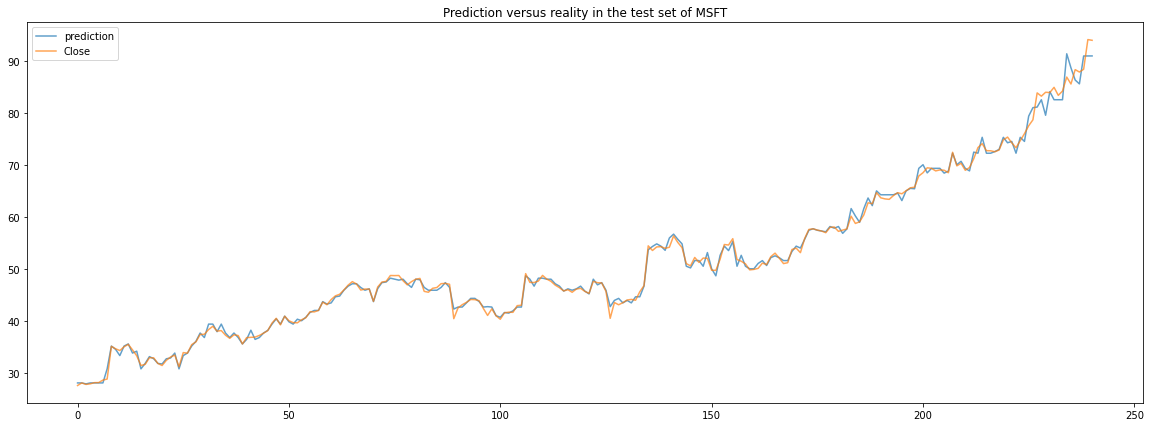

In [ ]:


from pyspark.ml.regression import GBTRegressor

MSFT=df.filter(df.Ticker == "MSFT")
MSFT=MSFT.select("Date","Open","High","Low","Volume","Close")
def GBT(MSFT,grid_search=False):
  tradata, tData = MSFT.randomSplit([0.8, 0.2])

  va = VectorAssembler().setInputCols(tradata.columns[1:5]).setOutputCol('features')
  gbt = GBTRegressor(featuresCol="features",labelCol="Close", maxIter=30,stepSize=0.0001,maxDepth=10)

  # Chain indexer and GBT in a Pipeline
  pipe = Pipeline(stages=[va, gbt])
  evaluator_gbt = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName='rmse')
  if grid_search:
    paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxIter, [10, 20,30]) \
        .addGrid(gbt.stepSize, [0.1,0.01,0.001,0.0001]) \
        .addGrid(gbt.maxDepth, [3,5,7,9,10,12]) \
        .build()


    crossval = CrossValidator(estimator=pipe,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator_gbt,
                              numFolds=2)  # use 3+ folds in practice

  # Run cross-validation, and choose the best set of parameters to Train a GBT model.
    model_gbt=crossval.fit(tradata)
    hyperparams = model_gbt.getEstimatorParamMaps()[np.argmax(model_gbt.avgMetrics)]
    print(hyperparams)
    model_gbt = model_gbt.bestModel
  else:
    model_gbt = pipe.fit(tradata)
  pred_gbt = model_gbt.transform(tData)

  rmse1_gbt = evaluator_gbt.evaluate(pred_gbt)

  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1_gbt)
  return pred_gbt,tData,rmse1_gbt
pred_gbt,tData,rmse1_gbt = GBT(MSFT)

#Line plot comparing Prediction versus reality in the test set of msft
msft= pred_gbt.toPandas()
tes=tData.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(msft)), msft.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(tes)), tes.Close, alpha=0.7, label='Close' );
plt.title('Prediction versus reality in the test set of MSFT')
plt.legend();

In [ ]:
pred_gbt.toPandas()

,Date,Open,High,Low,Volume,Close,features,prediction
0,2013-02-08,27.3500,27.71,27.3100,33318306,27.550,"[27.35, 27.71, 27.31, 33318306.0]",28.045231
1,2013-02-19,27.8801,28.09,27.8000,38804616,28.045,"[27.8801, 28.09, 27.8, 38804616.0]",28.045529
2,2013-02-22,27.6800,27.76,27.4800,31425726,27.760,"[27.68, 27.76, 27.48, 31425726.0]",27.859874
3,2013-03-11,27.9400,27.97,27.6700,36627200,27.870,"[27.94, 27.97, 27.67, 36627200.0]",28.045210
4,2013-03-18,27.8800,28.28,27.8100,44825522,28.100,"[27.88, 28.28, 27.81, 44825522.0]",28.045296
...,...,...,...,...,...,...,...,...
236,2018-01-08,88.2000,88.58,87.6046,22113049,88.280,"[88.2, 88.58, 87.6046, 22113049.0]",86.280000
237,2018-01-10,87.8600,88.19,87.4100,18652201,87.820,"[87.86, 88.19, 87.41, 18652201.0]",85.540052
238,2018-01-16,90.1000,90.79,88.0104,36599736,88.350,"[90.1, 90.79, 88.0104, 36599736.0]",90.904737
239,2018-01-26,93.1200,94.06,92.5800,29172167,94.060,"[93.12, 94.06, 92.58, 29172167.0]",90.910000


In [ ]:
#Printing the date and price when the MSFT stock reached its highest value (High)

print(MSFT.orderBy(MSFT["High"].desc()).head(1)[0][0]) # print date
print(MSFT.orderBy(MSFT["High"].desc()).head(1)[0][2]) # print price

2018-02-01
96.07


In [ ]:
#Daily return stats for MSFT

MSFT1=df.filter(df.Ticker == "MSFT")

MSFT1.describe("DailyReturn").show()

+-------+-------------------+
|summary|        DailyReturn|
+-------+-------------------+
|  count|               1259|
|   mean|0.08204052584046582|
| stddev|  1.059126172068903|
|    min| -5.048033342296907|
|    max|  4.983636985247283|
+-------+-------------------+



# 3. Linear Regression to predict close price for JNJ 

In [ ]:
from pyspark.ml.regression import LinearRegression

JNJ=df.filter(df.Ticker == "JNJ")
JNJ=JNJ.select("Date","Open","High","Low","Volume","Close")
def LR(JNJ):
  pipe_lr=Pipeline(stages=[feature.VectorAssembler(inputCols=['Open','High','Low','Volume'],outputCol="features"),regression.LinearRegression(featuresCol='features', labelCol='Close')])

  train_df,test_df=JNJ.randomSplit([0.7, 0.3], )
  paramGrid = ParamGridBuilder().build()

  lr_eval=RegressionEvaluator(predictionCol="prediction",labelCol="Close",metricName="rmse")
  crossval = CrossValidator(estimator=pipe_lr, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=lr_eval, 
                            numFolds=3)
  cval=crossval.fit(train_df)
  jnj_lr=cval.transform(test_df)


  print("the MSE of the LR model (on test data) is:",lr_eval.evaluate(jnj_lr))
  return jnj_lr,test_df,lr_eval.evaluate(jnj_lr)
jnj_lr,test_df,rmse = LR(JNJ)

the MSE of the LR model (on test data) is: 0.40018995873950336


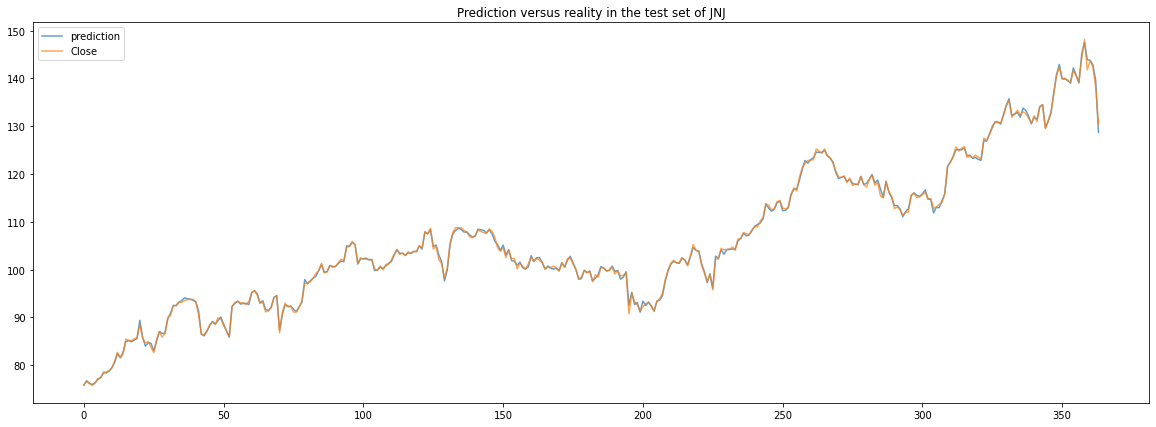

In [ ]:
#Line plot comparing Prediction versus reality in the test set of msft
jnj_pd= jnj_lr.toPandas()
tes_pd=test_df.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(jnj_pd)), jnj_pd.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(tes_pd)), tes_pd.Close, alpha=0.7, label='Close' );
plt.title('Prediction versus reality in the test set of JNJ')
plt.legend();

# Comparison of Models on Each Ticker

MMM
Root Mean Squared Error (RMSE) on test data = 1.71248
Root Mean Squared Error (RMSE) on test data = 1.55584
the MSE of the LR model (on test data) is: 0.5246943237307031
AXP
Root Mean Squared Error (RMSE) on test data = 0.469336
Root Mean Squared Error (RMSE) on test data = 0.455985
the MSE of the LR model (on test data) is: 0.3072022146466326
AAPL
Root Mean Squared Error (RMSE) on test data = 1.08839
Root Mean Squared Error (RMSE) on test data = 1.23942
the MSE of the LR model (on test data) is: 0.5285932764129863
CSCO
Root Mean Squared Error (RMSE) on test data = 0.292499
Root Mean Squared Error (RMSE) on test data = 0.389968
the MSE of the LR model (on test data) is: 0.12930335514776636
XOM
Root Mean Squared Error (RMSE) on test data = 0.345993
Root Mean Squared Error (RMSE) on test data = 0.336499
the MSE of the LR model (on test data) is: 0.35080521572268675
JPM
Root Mean Squared Error (RMSE) on test data = 1.37583
Root Mean Squared Error (RMSE) on test data = 0.822247
the MSE

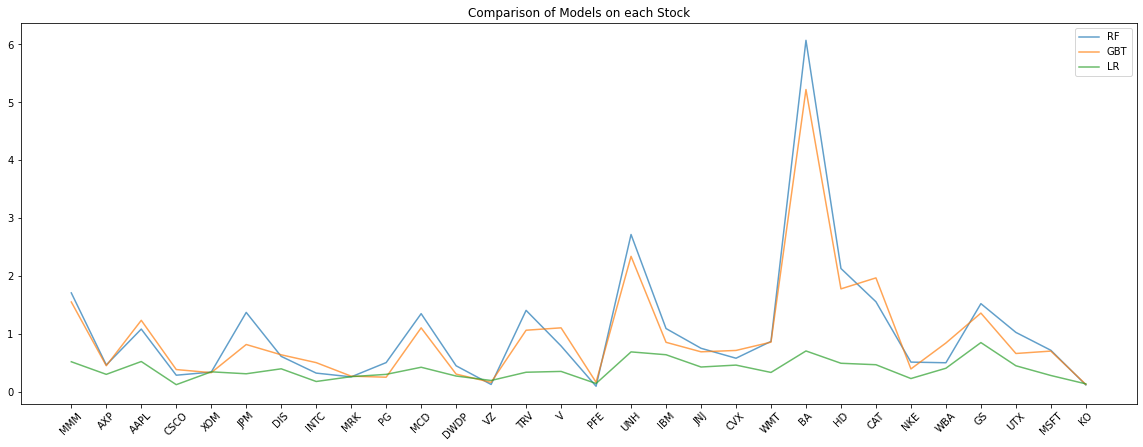

In [ ]:
stats = [[],[],[]]
companyList = ['MMM','AXP','AAPL','CSCO','XOM','JPM','DIS','INTC','MRK','PG','MCD','DWDP','VZ','TRV','V','PFE','UNH','IBM','JNJ','CVX','WMT','BA','HD','CAT','NKE','WBA','GS','UTX','MSFT','KO']
for company in companyList:
  CompanyStocks = df.orderBy("Date").filter(df.Ticker == company)
  print(company)
  _,_,rf_rmse = RF(CompanyStocks)
  _,_,gbt_rmse = GBT(CompanyStocks)
  _,_,lr_rmse = LR(CompanyStocks)
  stats[0].append(rf_rmse)
  stats[1].append(gbt_rmse)
  stats[2].append(lr_rmse)
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(stats[0])), stats[0], alpha=0.7, label='RF')
plt.plot(np.arange(len(stats[1])), stats[1], alpha=0.7, label='GBT')
plt.plot(np.arange(len(stats[2])), stats[2], alpha=0.7, label='LR')
plt.xticks(np.arange(len(stats[0])),companyList,rotation=45)
plt.title('Comparison of Models on each Stock')
plt.legend(loc=0);
plt.show()

# Various Moving Average plots for Johnson & Johnson (JNJ). 



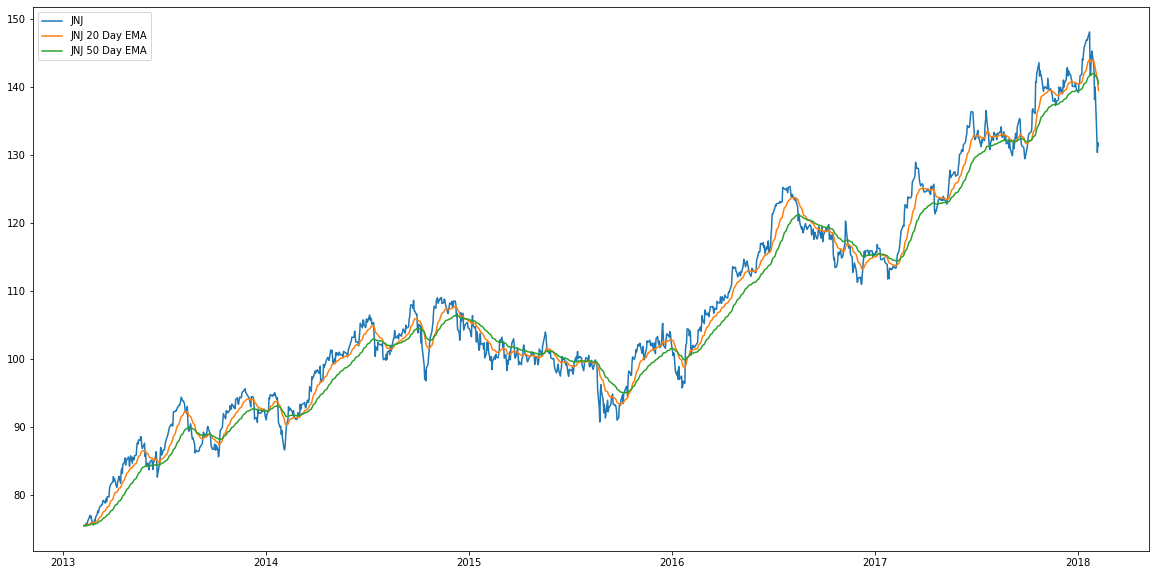

In [ ]:
JN=df.filter(df.Ticker == "JNJ")
JN=JN.select("Date","Open","High","Low","Volume","Close")
JN1=JN.toPandas()

exp1 = JN1.Close.ewm(span=20, adjust=False).mean()
exp2 = JN1.Close.ewm(span=50, adjust=False).mean()
plt.figure(figsize=(20,10))
plt.plot(JN1.Date, JN1.Close, label='JNJ')
plt.plot(JN1.Date, exp1, label='JNJ 20 Day EMA')
plt.plot(JN1.Date, exp2, label='JNJ 50 Day EMA')
plt.legend(loc='upper left')
plt.show()

#when the shorter day moving average crosses the longer term moving average it generates a 'buy' signal and when the longer term moving average crosses the shorter term moving average we get a 'sell' signal.

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

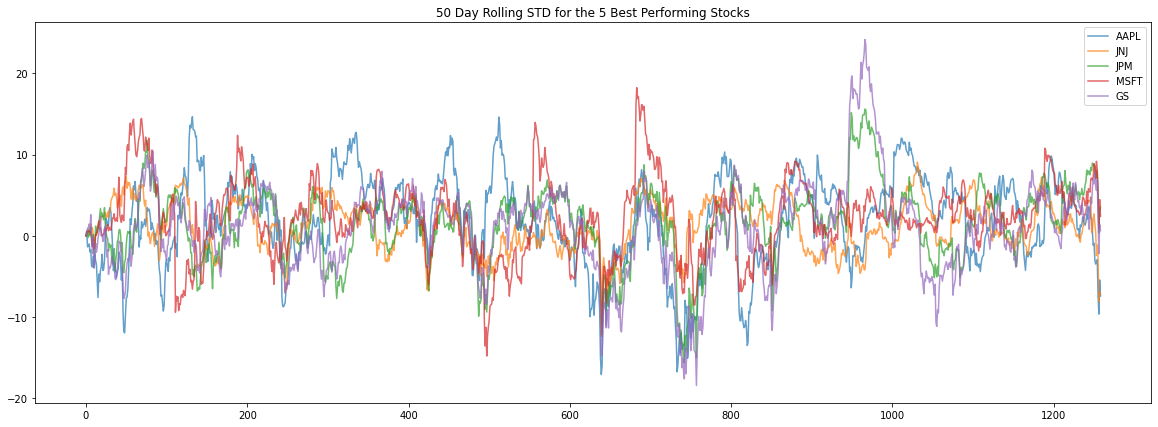

In [ ]:
# Create a window between today and 50 days ago.
windowSpec = Window.orderBy(col("Date")).rowsBetween(-50, 0)
plt.figure(figsize=(20,7))

# for company in ['MMM','AXP','AAPL','CSCO','XOM','JPM','DIS','INTC','MRK','PG','MCD','DWDP','VZ','TRV','V','PFE','UNH','IBM','JNJ','CVX','WMT','BA','HD','CAT','NKE','WBA','GS','UTX','MSFT','KO']:
for company in ["AAPL", "JNJ", "JPM", "MSFT", "GS"]:
  CompanyStocks = df.orderBy("Date").filter(df.Ticker == company)

  # Calculate new moving average column using 'avg' and the windowSpec
  CompanyStocks = CompanyStocks.withColumn('50DMA', avg("Close").over(windowSpec)) 
  deviation = log(col('Close')/col('50DMA'))*100
  CompanyStocks = CompanyStocks.withColumn("50_DMA_DEV", deviation)
  cs_df = CompanyStocks.select(['Date','Close','50DMA','50_DMA_DEV']).toPandas()
  # plt.plot(np.arange(len(cs_df)), cs_df["Close"], alpha=0.7, label='Close')
  plt.plot(np.arange(len(cs_df)), cs_df["50_DMA_DEV"], alpha=0.7, label='{}'.format(company))
  # plt.plot(np.arange(len(cs_df)), cs_df["50DMA"], alpha=0.7, label='Avg');
plt.title('50 Day Rolling STD for the 5 Best Performing Stocks')
plt.legend();
plt.show()